In [1]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')

In [2]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [3]:
import pandas.io.data as web
#from pandas_datareader import data as web
import pandas_datareader as pdr

In [4]:
#pdr.get_data_yahoo('NIFTYBEES.NS')
NB = web.DataReader(name='NIFTYBEES.NS', data_source='yahoo',start='2008-1-1')
NB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1925 entries, 2008-01-01 to 2016-07-15
Data columns (total 6 columns):
Open         1925 non-null float64
High         1925 non-null float64
Low          1925 non-null float64
Close        1925 non-null float64
Volume       1925 non-null int64
Adj Close    1925 non-null float64
dtypes: float64(5), int64(1)
memory usage: 105.3 KB


In [5]:
#Assumption: last day's US market close has impact on NIFTY
SPY = web.DataReader(name='SPY', data_source='yahoo',start='2008-1-1')
SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2150 entries, 2008-01-02 to 2016-07-15
Data columns (total 6 columns):
Open         2150 non-null float64
High         2150 non-null float64
Low          2150 non-null float64
Close        2150 non-null float64
Volume       2150 non-null int64
Adj Close    2150 non-null float64
dtypes: float64(5), int64(1)
memory usage: 117.6 KB


In [92]:
#NB['Change'] = np.sign(np.log(NB['Open'] /NB['Close'].shift(1)))
NB['Change'] = np.log(NB['Open'] /NB['Close'].shift(1))

In [6]:
NB['Open Change']= np.where(NB['Open']>NB['Close'].shift(1),1,np.where(NB['Open']<NB['Close'].shift(1),-1,0))

In [7]:
SPY['US_Mkt']= np.where(SPY['Close']>SPY['Close'].shift(1),1,np.where(SPY['Close']<SPY['Close'].shift(1),-1,0))

In [8]:
NB['Volume']=NB['Volume']/pd.rolling_mean(NB['Volume'],10)

In [9]:
NB['US_Mkt']=SPY['US_Mkt'].shift(1)

In [12]:
NB['Volatility']=NB['Close'].apply(lambda x: np.log(x))/pd.rolling_std(NB['Close'],21)

In [11]:
flagD=np.logical_and(np.logical_and(NB['Open'].shift(2)<NB['Close'].shift(3),NB['Open'].shift(1)< NB['Close'].shift(2)),NB['Open']< NB['Close'].shift(1))
flagU=np.logical_and(np.logical_and(NB['Open'].shift(2)>NB['Close'].shift(3),NB['Open'].shift(1)> NB['Close'].shift(2)),NB['Open']> NB['Close'].shift(1))

In [13]:
NB['3UD']= np.where(flagU,-1,np.where(flagD,1,0))

In [14]:
import TA# self made python file at PyCON16 folder for TA
#https://mrjbq7.github.io/ta-lib/func.html
import talib

In [36]:
#Calculating momentum of the close prices, with a time period of 5:
NB['momentum_'] = np.where(talib.MOM(np.asarray(NB['Close']), timeperiod=14)>50,1,np.where(talib.MOM(np.asarray(NB['Close']), timeperiod=14)<-50,-1,0))
NB['momentum'] = talib.MOM(np.asarray(NB['Close']), timeperiod=5)

In [35]:
NB['RSI_'] = np.where(talib.RSI(np.asarray(NB['Close']), timeperiod=14)>60,1,np.where(talib.RSI(np.asarray(NB['Close']), timeperiod=14)<45,-1,0))
NB['RSI'] = talib.RSI(np.asarray(NB['Close']), timeperiod=14)

In [18]:
  # reads data from Google Finance
NB['14d'] = pd.rolling_mean(NB['Close'], 14)
NB['42d'] = pd.rolling_mean(NB['Close'], 42)
  # 42d and 252d trends
NB['Cross']=np.where(NB['14d']>NB['42d'], 1,np.where(NB['14d']<NB['42d'],-1,0))

In [37]:
NB['BS2']=np.where(np.logical_and(np.logical_and(NB['momentum_']==1,NB['RSI_']==1),NB['Cross']==1),-1,np.where(np.logical_and(np.logical_and(NB['momentum_']==-1,NB['RSI_']==-1),NB['Cross']==-1),1,0))

In [38]:
NB=NB.dropna()

In [93]:
print(NB.head())

            Open   High     Low   Close    Volume  Adj Close  Open Change  \
Date                                                                        
2008-03-19   471  481.0  462.10  463.22  0.541796     454.57            1   
2008-03-24   461  472.0  454.95  463.28  2.290142     454.63           -1   
2008-03-25   473  493.0  473.00  490.17  1.084630     481.02            1   
2008-03-26   492  494.0  486.05  489.15  0.588848     480.02            1   
2008-03-27   487  491.7  483.00  488.27  0.641767     479.16           -1   

            US_Mkt  Volatility  3UD  momentum        RSI         14d  \
Date                                                                   
2008-03-19       1    0.236933    0    -31.03  24.415525  489.195714   
2008-03-24       1    0.235345    0     -7.67  24.452459  484.429286   
2008-03-25       1    0.244263    0     11.59  38.869415  482.062857   
2008-03-26       1    0.251964    0     30.53  38.568750  480.787857   
2008-03-27      -1    0.2593

In [43]:
#X=NB[['Volume','US_Mkt','Volatility','3UD','momentum','RSI','Cross','BS2']]
X=NB[['Volume','Volatility','momentum','RSI']]

In [27]:
#X.dropna()

In [80]:
y=NB[['Change']]

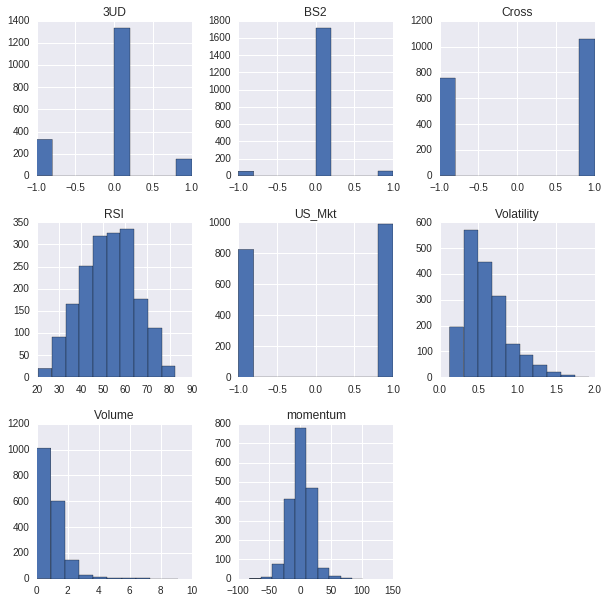

In [42]:
pd.DataFrame.hist(X, figsize = [10,10]);

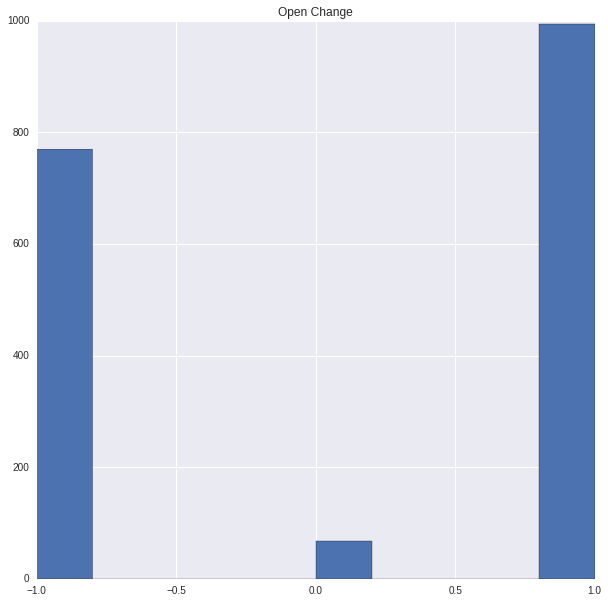

In [32]:
pd.DataFrame.hist(y, figsize = [10,10]);

In [81]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
from sklearn.svm import SVR
svm = SVR(kernel='linear')
svm_model_1 = svm.fit(X_train, y_train)
print('SVR accuracy for test set: %f' % svm_model_1.score(X_test, y_test))

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:216: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64)


SVR accuracy for test set: -0.545749


In [83]:
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin = svr_lin.fit(X_train, y_train).predict(X_test)
y_poly = svr_poly.fit(X_train, y_train).predict(X_test)

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:216: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64)
/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:216: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64)
/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:216: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64)


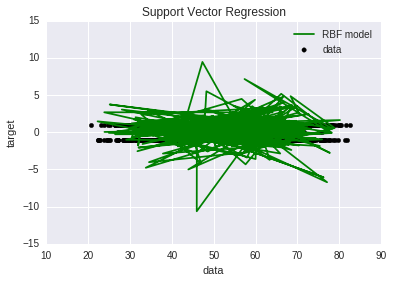

In [88]:
# look at the results
plt.scatter(X['RSI'], y, c='k', label='data')
plt.hold('on')
plt.plot(X_test['RSI'], y_rbf, c='g', label='RBF model')
#plt.plot(X_test, y_lin, c='r', label='Linear model')
#plt.plot(X_test, y_poly, c='b', label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [91]:
#predicted value
y_rbf[0],y.tail()

(0.45667821944141673,             Change
 Date              
 2016-07-11       1
 2016-07-12       1
 2016-07-13      -1
 2016-07-14       1
 2016-07-15       1)

In [52]:
X.tail(1)

,Volume,Volatility,momentum,RSI
Date,,,,
2016-07-15,0.627615,0.452437,22.6,73.69074
